In [1]:
import numpy as np
import scipy.io

# Load the training data
train_data = scipy.io.loadmat('train_data.mat')
X_train = train_data['x']  # Assuming 'X' is the key for the image data

# Reshape the data

if X_train.shape[1] != 784:
    X_train = X_train.reshape(X_train.shape[0], -1)

# Compute mean and standard deviation for each feature
mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)

# Function to normalize data
def normalize_data(X, mean, std):
    return (X - mean) / std

# Normalize training data
X_train_norm = normalize_data(X_train, mean, std)

# Load and normalize test data
test_data = scipy.io.loadmat('test_data.mat')
X_test = test_data['x']  #'x' is the key for the image data

# Reshape test data 
if X_test.shape[1] != 784:
    X_test = X_test.reshape(X_test.shape[0], -1)

X_test_norm = normalize_data(X_test, mean, std)

print("Shape of normalized training data:", X_train_norm.shape)
print("Shape of normalized test data:", X_test_norm.shape)


Shape of normalized training data: (12000, 784)
Shape of normalized test data: (2000, 784)


In [51]:
import numpy as np
import scipy.io


# PCA using the training samples

def perform_pca(X):
    # Compute the covariance matrix
    cov_matrix = np.cov(X.T)
    
    # Perform eigen analysis
    eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)
    
    # Sorting eigenvectors by decreasing eigenvalues
    ord = eigenvalues.argsort()[::-1] # to keep more relevant features on top
    eigenvalues = eigenvalues[ord]
    eigenvectors = eigenvectors[:, ord]
    
    # The columns of eigenvectors are the principal components
    principal_comp = eigenvectors
    
    return principal_comp, eigenvalues

#  PCA on the normalized training data
principal_comp, eigenvalues = perform_pca(X_train_norm)


print("Shape of principal components:", principal_comp.shape)

print("First 10 eigenvalues:", eigenvalues[:10])


Shape of principal components: (784, 784)
First 10 eigenvalues: [277.98413557  70.48905474  42.53320755  29.98819086  20.10843964
  16.74890162  12.60271958  11.83138131  10.99029787   9.43059096]


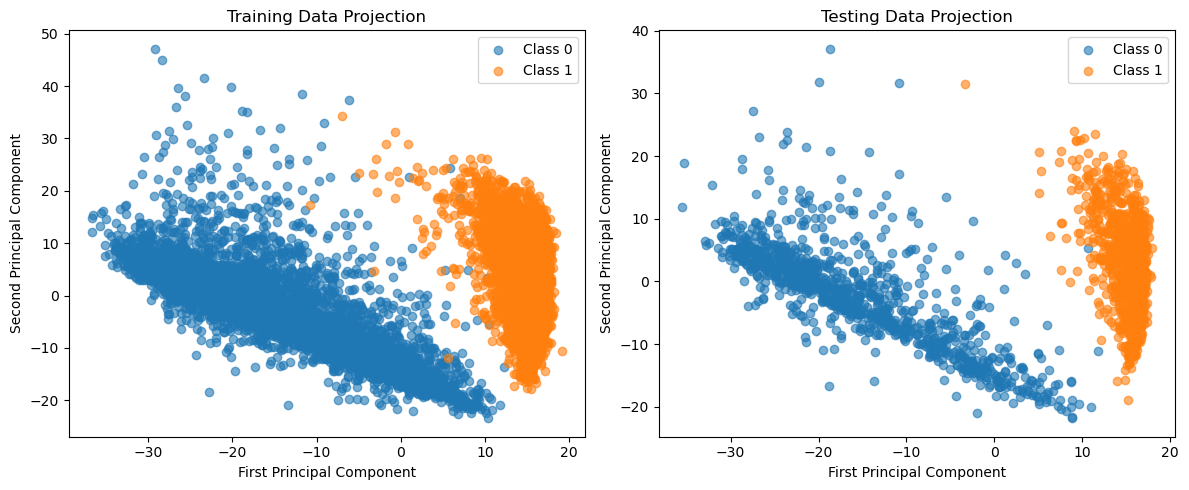

In [53]:
import numpy as np
import scipy.io
import matplotlib.pyplot as plt

def project_data(X, principal_comp, n_components=2):
    if X.shape[1] != principal_comp.shape[0]:
        raise ValueError("Dimensions of data and principal components do not match")
    if n_components > principal_components.shape[1]:
        raise ValueError("Requested more components than available")
    return np.dot(X, principal_comp[:, :n_components])

def plot_projected_data(X_projected, y, title):
    for class_label in np.unique(y):
        mask = y == class_label
        plt.scatter(X_projected[mask, 0], X_projected[mask, 1], 
                    label=f'Class {class_label}', alpha=0.6)
    plt.title(title)
    plt.xlabel('First Principal Component')
    plt.ylabel('Second Principal Component')
    plt.legend()

try:
    # Project data
    X_train_projected = project_data(X_train_norm, principal_comp)
    X_test_projected = project_data(X_test_norm, principal_comp)

    # Extract labels
    y_train = train_data.get('y', None)
    y_test = test_data.get('y', None)

    if y_train is None or y_test is None:
        raise KeyError("Labels 'y' not found in data files")

    y_train = y_train.ravel()
    y_test = y_test.ravel()

    # Plotting
    plt.figure(figsize=(12, 5))

    plt.subplot(121)
    plot_projected_data(X_train_projected, y_train, 'Training Data Projection')

    plt.subplot(122)
    plot_projected_data(X_test_projected, y_test, 'Testing Data Projection')

    plt.tight_layout()
    plt.show()

except (ValueError, KeyError) as e:
    print(f"Error: {e}")
except Exception as e:
    print(f"An unexpected error occurred: {e}")


Class 0 parameters:
Mean: [-14.96013579  -2.53759713]
Covariance matrix:
[[103.38209995 -69.15661464]
 [-69.15661464  73.43418283]]

Class 1 parameters:
Mean: [14.96013579  2.53759713]
Covariance matrix:
[[ 4.94656978 -6.78163691]
 [-6.78163691 54.67473161]]


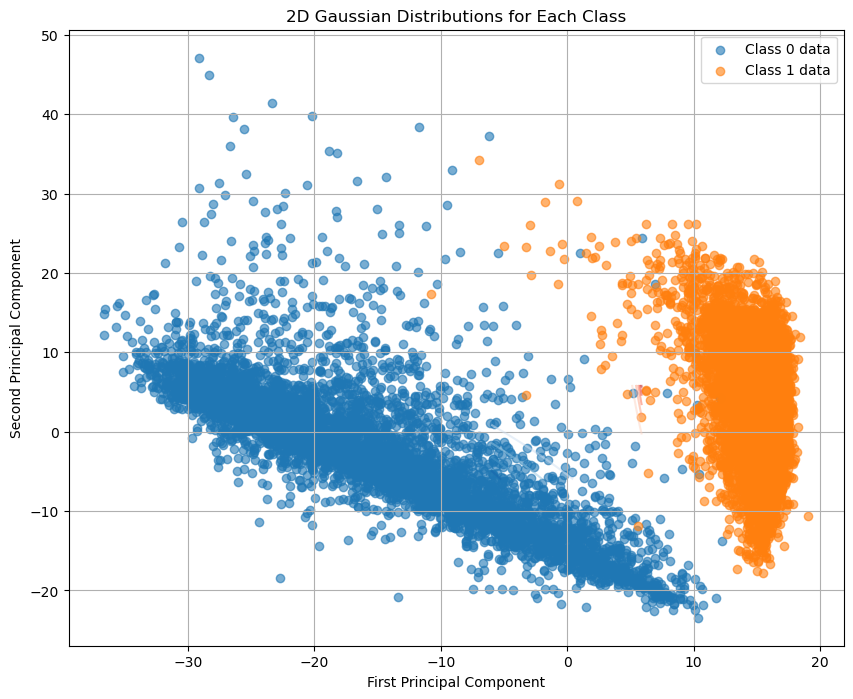

In [41]:
import numpy as np
from scipy.stats import multivariate_normal


# Density Estimation

def estimate_gaussian_parameters(X, y):
    classes = np.unique(y)
    params = {}
    
    for c in classes:
        X_c = X[y == c]
        mean = np.mean(X_c, axis=0)
        cov = np.cov(X_c, rowvar=False)
        params[c] = {'mean': mean, 'cov': cov}
    
    return params

# Estimating parameters for each class using the projected training data
gauss_params = estimate_gaussian_parameters(X_train_projected, y_train)

for c, params in gauss_params.items():
    print(f"\nClass {c} parameters:")
    print(f"Mean: {params['mean']}")
    print(f"Covariance matrix:\n{params['cov']}")

# Visualizing the estimated distributions
plt.figure(figsize=(10, 8))

# Plot the training data points
for c in np.unique(y_train):
    mask = y_train == c
    plt.scatter(X_train_projected[mask, 0], X_train_projected[mask, 1], 
                label=f'Class {c} data', alpha=0.6)

# Plot the estimated distributions
x, y = np.mgrid[-6:6:.1, -6:6:.1]
pos = np.dstack((x, y))

for c, params in gauss_params.items():
    rv = multivariate_normal(params['mean'], params['cov'])
    plt.contour(x, y, rv.pdf(pos), levels=5, cmap=f'Blues' if c == 0 else 'Reds', alpha=0.5)

plt.title('2D Gaussian Distributions for Each Class')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.legend()
plt.grid(True)
plt.show()



Training set accuracy: 99.75%
Testing set accuracy: 99.90%


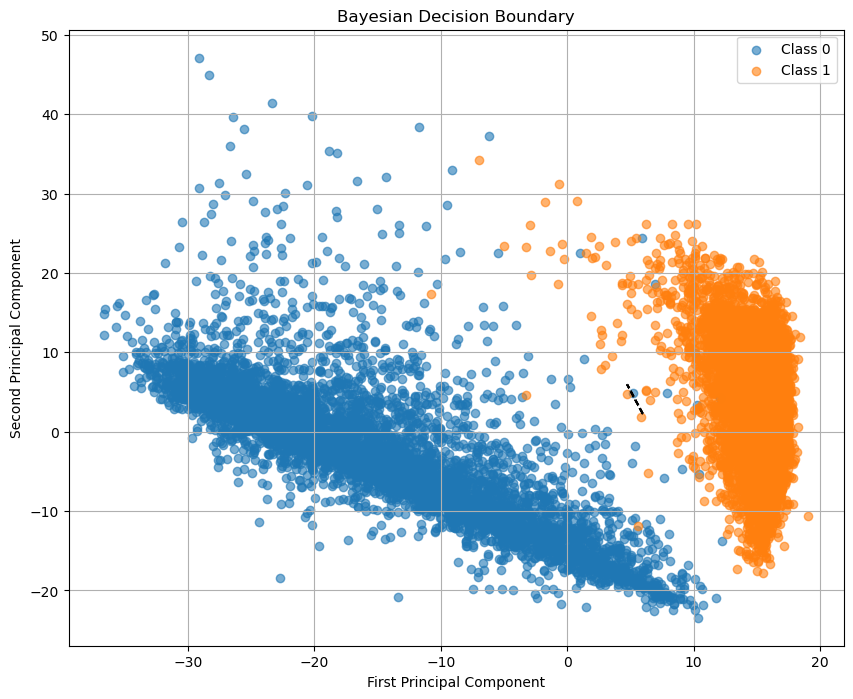

In [49]:
import numpy as np
from scipy.stats import multivariate_normal


# Bayesian Decision Theory for optimal classification

def bayes_classifier(X, gauss_params, prior_probs):
    classes = list(gauss_params.keys())
    posteriors = np.zeros((X.shape[0], len(classes)))
    
    for i, c in enumerate(classes):
        likelihood = multivariate_normal(gauss_params[c]['mean'], gauss_params[c]['cov']).pdf(X)
        posteriors[:, i] = likelihood * prior_probs[c]
    
    return np.argmax(posteriors, axis=1)

def calculate_accuracy(y_true, y_pred):
    return np.mean(y_true == y_pred) * 100

# Set prior probabilities 
prior_probs = {0: 0.5, 1: 0.5}

# Classify training data
y_train_pred = bayes_classifier(X_train_projected, gauss_params, prior_probs)
train_accuracy = calculate_accuracy(y_train, y_train_pred)

# Classify testing data
y_test_pred = bayes_classifier(X_test_projected, gauss_params, prior_probs)
test_accuracy = calculate_accuracy(y_test, y_test_pred)

print(f"Training set accuracy: {train_accuracy:.2f}%")
print(f"Testing set accuracy: {test_accuracy:.2f}%")

# Visualize the decision boundary
plt.figure(figsize=(10, 8))

# Plot the training data points
for c in np.unique(y_train):
    mask = y_train == c
    plt.scatter(X_train_projected[mask, 0], X_train_projected[mask, 1], 
                label=f'Class {c}', alpha=0.6)

# Create a grid of points
x, y = np.mgrid[-6:6:.01, -6:6:.01]
pos = np.dstack((x, y))

# Classify each point in the grid
grid_z = bayesian_classifier(pos.reshape(-1, 2), gauss_params, prior_probs)
grid_z = grid_z.reshape(x.shape)

# Plot the decision boundary
plt.contour(x, y, grid_z, levels=[0.5], colors='k', linestyles='dashed')

plt.title('Bayesian Decision Boundary')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.legend()
plt.grid(True)
plt.show()

